In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

### Simulation

In [43]:
sim = rw.Simulation()

nr_particles = 1*10**5
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
energy = 10**12 # eV
source = rw.PointSourceIsotropicPhi(energy, source_pos, nr_particles)
sim.add_source(source)

nr_steps = 1*10**5
step_size = 1.0*10**11 # [m]
diffusion_coefficient = 1.5*10**21 # [m^2/s]
speed_of_light = 3*10**8 # [m/s]
mfp_iso = 3*diffusion_coefficient/speed_of_light
mfp = np.array([mfp_iso, mfp_iso, mfp_iso], dtype=np.float32)  # [m]
propagator = rw.IsotropicPropagator(mfp, nr_steps, step_size)
sim.add_propagator(propagator)

substeps = [False, False, True] # observe only steps (no substeps)
sphere = 10**14 # [m]
spheres = [sphere]
observer = rw.SphericalObserver(substeps, spheres, on_detection_deactivate=True)
sim.add_observer(observer)

start simulation
Propagator initialized
Observer initialized


In [37]:
%time sim.run_simulation()
sim.save_data('data/data_tut_5')

start simulation
Propagator initialized
Observer initialized
CPU times: user 7min 49s, sys: 257 ms, total: 7min 50s
Wall time: 7min 50s
saved data file data/data_tut_5.pkl


### Analysis

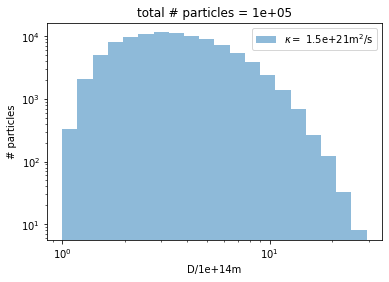

In [50]:
df = pd.read_pickle("data/data_tut_5.pkl")
bins = 20
trajectory_lengths = df['d']
d = trajectory_lengths/10**14
hist, bins = np.histogram(d, bins=bins)
logbins = np.logspace(np.log10(min(d)),np.log10(max(d)),len(bins))
plt.hist(d, bins=logbins, alpha=0.5, label='$\kappa =$ {:.1e}m$^2$/s'.format(diffusion_coefficient))

plt.title('total # particles = {:.0e}'.format(nr_particles))
plt.xlabel('D/{:.0e}m'.format(sphere))
plt.ylabel('# particles')
plt.loglog()
plt.legend()
plt.savefig('traj_lengths_rwpropa.png')
plt.show()

(array([15., 22., 22., 23.,  4.,  5.,  4.,  2.,  0.,  1.]),
 array([6.51654249e+14, 1.57873139e+15, 2.50580853e+15, 3.43288567e+15,
        4.35996281e+15, 5.28703995e+15, 6.21411709e+15, 7.14119423e+15,
        8.06827137e+15, 8.99534851e+15, 9.92242565e+15]),
 <BarContainer object of 10 artists>)

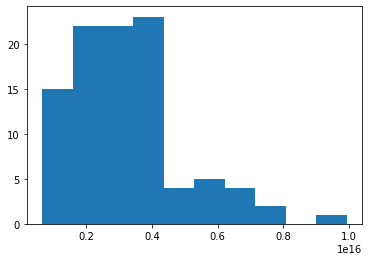

In [25]:
plt.hist(df['d'], bins=10)

In [51]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,6331.0,6.331433e+14,-6.408548e+13,7.493991e+13,1.674311e+13,2.104218,0.955393,1.000000e+14,2.0
1,1.0,4106.0,4.106647e+14,3.290897e+12,-5.733053e+13,8.192631e+13,5.192996,4.096986,1.000000e+14,2.0
2,2.0,2120.0,2.121119e+14,-4.994050e+13,2.095773e+13,8.412038e+13,3.416327,0.955393,1.000000e+14,2.0
3,3.0,2362.0,2.363140e+14,4.012562e+13,9.162642e+13,1.212435e+12,3.480489,4.096986,1.000000e+14,2.0
4,4.0,5480.0,5.480079e+14,7.869294e+13,6.408593e+12,6.137195e+13,3.178626,0.955393,1.000000e+14,2.0
...,...,...,...,...,...,...,...,...,...,...
99995,99995.0,3309.0,3.309976e+14,5.692639e+13,-8.152214e+13,-1.073871e+13,3.768871,0.955393,1.000000e+14,2.0
99996,99996.0,10879.0,1.088213e+15,-3.464100e+12,3.695044e+12,9.988307e+13,5.230603,4.096986,1.000000e+14,2.0
99997,99997.0,2386.0,2.387143e+14,2.061133e+13,-2.430634e+13,9.485980e+13,5.700218,0.955393,1.000000e+14,2.0
99998,99998.0,2429.0,2.430147e+14,-5.080652e+13,1.501110e+12,8.614124e+13,5.452890,0.955393,1.000000e+14,2.0


In [63]:
sim = rw.IsotropicSimulation(nr_particles = 10**3, energy = energy, nr_steps = nr_steps/100, diffusion_coefficient_para = diffusion_coefficient, nr_obs_steps = 600)
%time sim.simulate()

simulate with a diffusion coefficient of  1.5e+21 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file isotropic.pkl
CPU times: user 5.61 s, sys: 96.1 ms, total: 5.71 s
Wall time: 5.82 s


init statistics plotting class


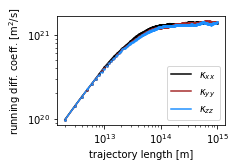

diffusion coefficients computed between 3.20e+14m and 1.00e+15m with 100 data points
kappa_{xx}: 1.39e+21 m²/s +- 1.83e+19 m²/s
kappa_{yy}: 1.4e+21 m²/s +- 2.85e+19 m²/s
kappa_{zz}: 1.35e+21 m²/s +- 3.38e+19 m²/s


In [64]:
df = pd.read_pickle("isotropic.pkl")
sta = rw.Statistics(df)
df_kappas = sta.plot_diffusion_coefficients(n_points_plateau=100)

In [65]:
import pandas as pd
df = pd.read_pickle("data/data_tut_5.pkl")
d = df['d'].values
print('{:.1e}'.format(np.mean(d)),'+/-', '{:.1e}'.format(np.std(d)), 'm')

4.1e+14 +/- 2.5e+14 m


In [67]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,6331.0,6.331433e+14,-6.408548e+13,7.493991e+13,1.674311e+13,2.104218,0.955393,1.000000e+14,2.0
1,1.0,4106.0,4.106647e+14,3.290897e+12,-5.733053e+13,8.192631e+13,5.192996,4.096986,1.000000e+14,2.0
2,2.0,2120.0,2.121119e+14,-4.994050e+13,2.095773e+13,8.412038e+13,3.416327,0.955393,1.000000e+14,2.0
3,3.0,2362.0,2.363140e+14,4.012562e+13,9.162642e+13,1.212435e+12,3.480489,4.096986,1.000000e+14,2.0
4,4.0,5480.0,5.480079e+14,7.869294e+13,6.408593e+12,6.137195e+13,3.178626,0.955393,1.000000e+14,2.0
...,...,...,...,...,...,...,...,...,...,...
99995,99995.0,3309.0,3.309976e+14,5.692639e+13,-8.152214e+13,-1.073871e+13,3.768871,0.955393,1.000000e+14,2.0
99996,99996.0,10879.0,1.088213e+15,-3.464100e+12,3.695044e+12,9.988307e+13,5.230603,4.096986,1.000000e+14,2.0
99997,99997.0,2386.0,2.387143e+14,2.061133e+13,-2.430634e+13,9.485980e+13,5.700218,0.955393,1.000000e+14,2.0
99998,99998.0,2429.0,2.430147e+14,-5.080652e+13,1.501110e+12,8.614124e+13,5.452890,0.955393,1.000000e+14,2.0
